created: Tue Jan  5 15:09:15 2021

**Group 5 - Classification**

**V1 Innovation detection semi supervised**

@authors : Lilian Dulinge

This document is a first experience of semi supervised learning for predict if a document is consider as innovant or not. We define if a document is innovant or not for us with a function and we try to define if the others are (these don't classifie by the function). Else we return a document with all the features and the predictions for innovation.

In [1]:
import pandas as pd 
import numpy as np
import re
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px


from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
nltk.download('punkt')

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Input/Data_With_Features_Syntax.csv")

In [4]:
df_final = pd.read_json("/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Input/df_final_clean.json")

In [5]:
df = pd.merge(left=df, right=df_final, left_on='art_id', right_on='art_id')

In [6]:
art_lemma = pd.read_json('/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Output/Innovation/df_articles_lemma.json')

In [7]:
df = pd.merge(left=df, right=art_lemma, left_on='art_id', right_on='art_lemma_id')

In [8]:
df_lexique: pd.DataFrame = pd.read_json(
    "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Output/Innovation/df_lexique_lemma.json")

In [9]:
# Counts the number of words
def nb_word(text: list) -> int:
    """Documentation
      Parameters:
        text: texts of the article

      Out (if exists):
        nb_word: number of word in  the document
    """
    nb_words: list = []
    nb: int = 0
    # browse through the different texts
    for i in text:
        # removes special characters
        i.replace(',', ' ')
        i.replace('.', ' ')
        i.replace('!', ' ')
        i.replace('?', ' ')
        i.replace('/', ' ')
        # creates a list with all the words present in the text
        list_words: list = i.split()
        # counts the number of words present in the text
        nb_words.append(len(list_words))
    return nb_words

In [10]:
# Count the number of time where the words in the list appear
def count_key_words(data: pd.DataFrame, l: list) -> list:
    """Documentation
    Parameters:
        data: List of articles
        l: List of word that we will check in the sentences

    Out (if exists):
        res: List where each value is the number of time where key word appear in the article
    """
    list_mot_unique=[]
    list_mot_compose=[]
    for elem in l :
      cpt = 0
      for car in elem :
        if (car == " ") :
          cpt+=1
      if cpt==0 :
        list_mot_unique.append(elem)
      else :
        list_mot_compose.append(elem)
    res: list = []
    for i in tqdm(range(len(data))):
      sentence: str = data[i]
      if sentence is None:
        res.append(0)
      else:
        sentence = sentence.lower()
        sentence = sentence.split()
        t: int = 0
        for j in sentence:
          if (j in list(list_mot_unique)):
            t = t + 1
        sentence: str = data[i]
        for elem in list_mot_compose:
          if elem in sentence:
            t = t + 1
      res.append(t)
    return res

In [11]:
# Count the number of sentence
def phrases(data: pd.DataFrame, col: str) -> list:
    """Documentation
    Parameters:
        data: Dataframe with all the data
        columns: The columns of the dataframe that we will use

    Out (if exists):
        l: List where each value is the number of sentence in a article
    """

    l: list = []
    for i in range(len(data[col])):
        sentences: str = data[col][i]

        if not isinstance(sentences, str):
            sentences: str = str(sentences)

        if (sentences is None):
            count_sentence.append(0)
        else:
            sentences = sentences.replace("..", ".")
            sentences = sentences.replace("...", ".")
            sentences = sentences.replace("!", ".")
            sentences = sentences.replace("!!", ".")
            sentences = sentences.replace("!!!", ".")
            sentences = sentences.replace("?", ".")
            sentences = sentences.replace("??", ".")
            sentences = sentences.replace("???", ".")
            sentences = sentences.replace("?!", ".")
            sentences = sentences.replace("!?", ".")
            l.append(len(sent_tokenize(sentences)))

    return l

In [12]:
def innovation(data_nb1, data_nb2, data_ratio1, data_ratio2):
  res = []
  seuil = 0.05
  for i in tqdm(range(len(data_nb1))):
    valeur = data_nb1[i]*data_ratio1[i] + (data_nb2[i]*data_ratio2[i])
    if valeur > seuil :
      res.append(1)
    elif ((valeur < seuil) & (data_nb1[i] == 0) & (data_nb2[i] == 0)):
      res.append(0)
    elif ((valeur < seuil) & (data_ratio1[i] < 0.0002) & (data_nb2[i] < 0.0005)):
      res.append(0)
    else :
      res.append('?')
  return res

In [13]:
# Visualization of a 2D point cloud with a PCA
def graph_2d(data: pd.DataFrame, prediction: list, dic_values: dict, transparency: float = 0.15):
    """Documentation
    Parameters:
        data: the data that will be show on the plot
        prediction: the prediction that will be used to make distinction bewteen the differents class on the plot
        dic_values: the signification of every values in the prediction
        transparency: the transparency of the points on the graph
    """
    components = data.shape[1]
    sc: StandardScaler = StandardScaler()
    X: ndarray = sc.fit_transform(data)

    pca: PCA = PCA(n_components=components)
    X: ndarray = pca.fit_transform(X)

    plt.title('Titre')
    for name_modal in dic_values:
        plt.scatter(X[prediction == dic_values[name_modal], 0], X[prediction ==
                                                                  dic_values[name_modal], 1], alpha=transparency, label=name_modal)
    plt.legend()

In [14]:
# Visualization of a 3D point cloud with a PCA
def graph_3d(data: pd.DataFrame, prediction: list, axes=(0,1,2), opacity: int = 1):
    """Documentation
    Parameters:
        data: the data that will be show on the plot
        prediction: the prediction that will be used to make distinction bewteen the differents class on the plot
        axes: axes to plot
        opacity: the transparency of the points on the graph
    """
    components = data.shape[1]
    sc: StandardScaler = StandardScaler()
    X: ndarray = sc.fit_transform(data)

    pca: PCA = PCA(n_components=components)
    X: ndarray = pca.fit_transform(X)

    data_plot: pd.DataFrame = pd.DataFrame(X)
    data_plot["prediction"]: Series = prediction
    fig: Figure = px.scatter_3d(data_plot, x= 0, y= 1, z= 2, color='prediction', opacity=0.5)
    fig.show()

In [17]:
df["nb_key_words"]: pd.DataFrame = count_key_words(df["art_lemma"], df_lexique["key_words_lemma"])
df["nb_key_words_title"]: pd.DataFrame = count_key_words(df["art_title"], df_lexique["key_words_lemma"])
df["nb_words"]: pd.DataFrame = nb_word(df['art_content_x'])
df["nb_words_title"]: pd.DataFrame = nb_word(df['art_title'])
df["nb_sentences"]: pd.DataFrame  = phrases(df, 'art_content_x')
df["average_word_sentence"]: pd.DataFrame = df["nb_words"] / df["nb_sentences"]
df["ratio_word_title_on_word"]: pd.DataFrame  = df["nb_words_title"] / df["nb_words"]
df['ratio_key_words']: pd.DataFrame  = df['nb_key_words']/df['nb_words']
df['ratio_key_words']: pd.DataFrame  = df['ratio_key_words'].fillna(0)
df['ratio_key_sentences']: pd.DataFrame  = df['nb_key_words']/df['nb_sentences']
df['ratio_key_sentences']: pd.DataFrame  = df['ratio_key_sentences'].fillna(0)
df['ratio_key_word_title']: pd.DataFrame  = df['nb_key_words_title'] / df['nb_words_title']
df['ratio_key_word_title']: pd.DataFrame  = df['ratio_key_word_title'].fillna(0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [ ]:
df.head()

,art_id,art_content,art_content_html,art_extract_datetime,art_lang,art_title,art_url,src_name,src_type,src_url,src_img,art_auth,art_tag,Nb_key_words,Nb_key_words_title,Nb_words,Nb_words_title,Nb_sentences,average_word_sentence,ratio_word_title_on_word,exclamation,interrogation,ratio_key_words,ratio_key_sentences,ratio_key_word_title,netloc.com,nb_word_path,content_postive_score,title_postive_score,content_negative_score,title_negative_score,content_polarity_score,title_polarity_score,content_subjectivity_score,title_subjectivity_score,art_lemma_id,art_lemma,nb_art_lemma
0,1,La FNCDG et l’ANDCDG ont publié en septembre l...,"<p style=""text-align: justify;"">La FNCDG et l’...",22 septembre 2020,fr,9ème édition du Panorama de l’emploi territorial,http://fncdg.com/9eme-edition-du-panorama-de-l...,FNCDG,xpath_source,http://fncdg.com/actualites/,http://fncdg.com/wp-content/uploads/2020/09/im...,NaN,NaN,0,0,40,7,3,13.333333,0.175000,0,0,0.000000,0.000000,0.000000,['.com'],7,0.00,0.0,0.000,0.0,0.000000,0.0,0.000000,0.0,1,fncdg andcdg publier septembre 9eme edition pa...,24
1,2,Malgré la levée des mesures de confinement le ...,"<p style=""text-align: justify;"">Malgré la levé...",17 mars 2020,fr,ACTUALITÉS FNCDG / COVID19,http://fncdg.com/actualites-covid19/,FNCDG,xpath_source,http://fncdg.com/actualites/,http://fncdg.com/wp-content/uploads/2020/03/co...,NaN,NaN,1,0,157,4,4,39.250000,0.025478,0,0,0.012739,0.500000,0.000000,['.com'],2,0.03,0.0,0.000,0.0,0.400000,0.0,1.000000,0.0,2,malgre levee mesure confinemer 11 mai 2020 plu...,88
2,25,Quels étaient les objectifs poursuivis par le ...,"<p style=""text-align: justify;""><strong>Quels ...",24 octobre 2019,fr,"Interview de M. Olivier DUSSOPT, Secretaire d’...",http://fncdg.com/interview-de-m-olivier-dussop...,FNCDG,xpath_source,http://fncdg.com/actualites/,http://fncdg.com/wp-content/uploads/2019/10/in...,NaN,NaN,9,0,1340,19,54,24.814815,0.014179,0,4,0.002239,0.055556,0.000000,['.com'],19,0.00,0.0,0.006,0.0,0.026786,0.1,0.261905,0.1,25,quel objectif poursuivre gouvernement cadre re...,770
3,27,"La journée thématique, qui aura lieu durant le...","<p style=""text-align: justify;""><strong>La jo...",31 mai 2017,fr,Journée Thématique FNCDG « Les services de san...,http://fncdg.com/journee-thematique-fncdg-les-...,FNCDG,xpath_source,http://fncdg.com/actualites/,http://fncdg.com/wp-content/uploads/2017/05/pu...,NaN,NaN,3,0,124,13,3,41.333333,0.104839,0,0,0.024194,1.000000,0.076923,['.com'],11,0.00,0.0,0.000,0.0,0.000000,0.0,0.000000,0.0,27,journee thematiqu lieu durant salon preventica...,84
4,28,La 1ère journée thématique en région sur le th...,"<p style=""text-align: justify;"">La 1<sup>ère</...",13 mars 2017,fr,Journée Thématique FNCDG « Vers de nouveaux mo...,http://fncdg.com/journee-thematique-fncdg-vers...,FNCDG,xpath_source,http://fncdg.com/actualites/,http://fncdg.com/wp-content/uploads/2017/03/Sa...,NaN,NaN,0,0,182,12,5,36.400000,0.065934,0,0,0.000000,0.000000,0.000000,['.com'],10,0.00,0.0,0.000,0.0,0.000000,0.0,0.000000,0.0,28,1ere journee thematique region theme vers nouv...,118


In [ ]:
df['innovation_detection'] = innovation(df['Nb_key_words'],df['ratio_key_words'],df['Nb_key_words_title'],df['ratio_key_word_title'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [ ]:
df['innovation_detection'].value_counts()

?    4112
0    2981
1     367
Name: innovation_detection, dtype: int64

# Prepare Data

In [ ]:
df = df.sample(frac=1, random_state=15).reset_index(drop=True)

In [ ]:
df['index'] = df.index

In [ ]:
var_utile = df[['Nb_key_words','Nb_key_words_title','ratio_key_words','ratio_key_word_title','innovation_detection']]

In [ ]:
tout = var_utile[var_utile['innovation_detection'] != '?']
unlabeled = var_utile[var_utile['innovation_detection'] == '?']

In [ ]:
print(str(len(df)),str(len(tout)),str(len(unlabeled)))

7460 3348 4112


In [ ]:
trainData, testData = train_test_split(tout,
                                        test_size=0.2)

In [ ]:
X_train = trainData.drop('innovation_detection', axis=1)
y_train = trainData.innovation_detection

X_unlabeled = unlabeled.drop('innovation_detection', axis=1)

X_test = testData.drop('innovation_detection', axis=1)
y_test = testData.innovation_detection

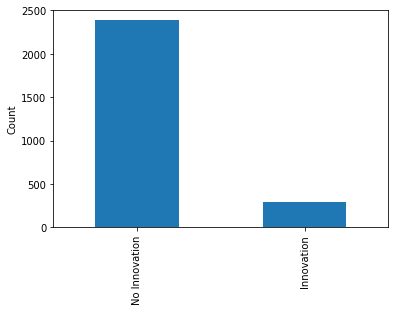

In [ ]:
y_train.value_counts().plot(kind='bar')
plt.xticks([0,1], ['No Innovation', 'Innovation'])
plt.ylabel('Count');

In [ ]:
y_train = pd.to_numeric(y_train)
y_test = pd.to_numeric(y_test)

# Mise en place de la phase d'apprentissage

## First classifier

### Choose the best classifier for these data

Train f1 Score: 1.0
Test f1 Score: 0.9931972789115647


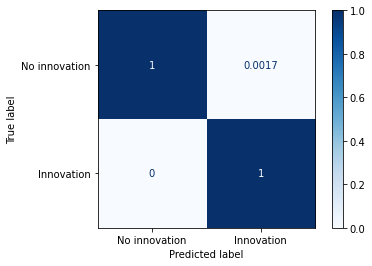

In [ ]:
# Logistic Regression

log = LogisticRegression(C=1e5)

log.fit(X_train, y_train)
y_hat_test = log.predict(X_test)
y_hat_train = log.predict(X_train)

train_f1 = f1_score(y_train, y_hat_train)
test_f1 = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

plot_confusion_matrix(log, X_test, y_test, cmap='Blues', normalize='true',
                     display_labels=['No innovation', 'Innovation']);

# le beau dammier

Train f1 Score: 1.0
Test f1 Score: 1.0


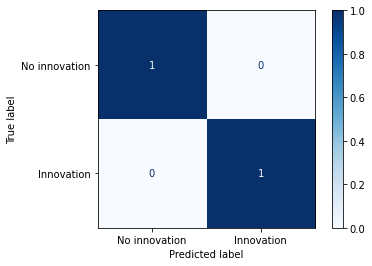

In [ ]:
# k Neighbors Classifier

knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
y_hat_test = knn.predict(X_test)
y_hat_train = knn.predict(X_train)

train_f1 = f1_score(y_train, y_hat_train)
test_f1 = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

plot_confusion_matrix(knn, X_test, y_test, cmap='Blues', normalize='true',
                     display_labels=['No innovation', 'Innovation']);

# le beau dammier

rbf :
Train f1 Score: 0.94351630867144
Test f1 Score: 0.9333333333333333

linear :
Train f1 Score: 0.94770206022187
Test f1 Score: 0.93687707641196

poly :
Train f1 Score: 0.8111011638316921
Test f1 Score: 0.7692307692307693

sigmoid :
Train f1 Score: 0.5902366863905325
Test f1 Score: 0.6178343949044586



Train f1 Score: 1.0
Test f1 Score: 0.9931972789115647


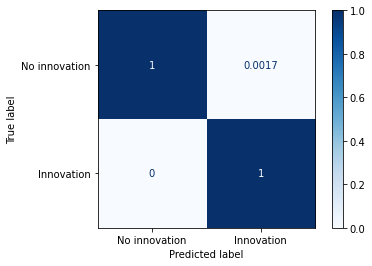

In [ ]:
# support vector machine

svc = svm.SVC(C = 4,kernel='linear', probability= True)

svc.fit(X_train, y_train)
y_hat_test = svc.predict(X_test)
y_hat_train = svc.predict(X_train)

train_f1 = f1_score(y_train, y_hat_train)
test_f1 = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

plot_confusion_matrix(svc, X_test, y_test, cmap='Blues', normalize='true',
                     display_labels=['No innovation', 'Innovation']);

# le beau dammier

Train f1 Score: 0.9948717948717948
Test f1 Score: 1.0


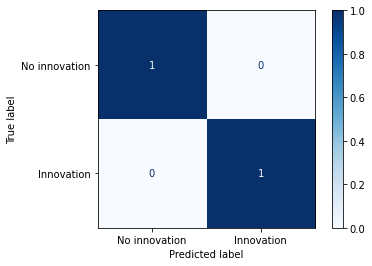

In [ ]:
# SGD classifier

clf = make_pipeline(StandardScaler(),
                     SGDClassifier(max_iter=1000, tol=1e-3, loss='log'))

clf.fit(X_train, y_train)
y_hat_test = clf.predict(X_test)
y_hat_train = clf.predict(X_train)

train_f1 = f1_score(y_train, y_hat_train)
test_f1 = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

plot_confusion_matrix(clf, X_test, y_test, cmap='Blues', normalize='true',
                     display_labels=['No innovation', 'Innovation']);

# le beau dammier

In [ ]:
# Generate probabilities for each prediction

clf.predict_proba(X_test)

array([[9.99119099e-01, 8.80901286e-04],
       [9.99119099e-01, 8.80901286e-04],
       [9.99119099e-01, 8.80901286e-04],
       ...,
       [9.99119099e-01, 8.80901286e-04],
       [9.85303170e-01, 1.46968298e-02],
       [9.89616306e-01, 1.03836937e-02]])

### After decision, train first classifier

In [ ]:
# Initiate iteration counter
iterations = 0

# Containers to hold f1_scores and # of pseudo-labels
train_f1s = []
test_f1s = []
pseudo_labels = []

# Assign value to initiate while loop
high_prob = [1] 

# Loop will run until there are no more high-probability pseudo-labels
while len(high_prob) > 0:
        
    # Fit classifier and make train/test predictions
    log = LogisticRegression(C=1e5)
    log.fit(X_train, y_train)
    y_hat_train = log.predict(X_train)
    y_hat_test = log.predict(X_test)

    # Calculate and print iteration # and f1 scores, and store f1 scores
    train_f1 = f1_score(y_train, y_hat_train)
    test_f1 = f1_score(y_test, y_hat_test)
    print(f"Iteration {iterations}")
    print(f"Train f1: {train_f1}")
    print(f"Test f1: {test_f1}")
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)
   
    if (len(X_unlabeled) > 0):
      # Generate predictions and probabilities for unlabeled data
      print(f"Now predicting labels for unlabeled data...")

      pred_probs : np.ndarray = log.predict_proba(X_unlabeled)
      preds : np.ndarray = log.predict(X_unlabeled)
      prob_0 : list = pred_probs[:,0]
      prob_1 : list = pred_probs[:,1]

      # Store predictions and probabilities in dataframe
      df_pred_prob : pd.DataFrame = pd.DataFrame([])
      df_pred_prob['preds'] = preds
      df_pred_prob['prob_0'] = prob_0
      df_pred_prob['prob_1'] = prob_1
      df_pred_prob.index = X_unlabeled.index
    
      # Separate predictions with > 99% probability
      high_prob : pd.DataFrame = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.99],
                           df_pred_prob.loc[df_pred_prob['prob_1'] > 0.99]],
                          axis=0)
    
      print(f"{len(high_prob)} high-probability predictions added to training data.")
    
      pseudo_labels.append(len(high_prob))

      # Add pseudo-labeled data to training data
      X_train = pd.concat([X_train, X_unlabeled.loc[high_prob.index]], axis=0)
      y_train = pd.concat([y_train, high_prob.preds])      
    
      # Drop pseudo-labeled instances from unlabeled data
      X_unlabeled = X_unlabeled.drop(index=high_prob.index)
      print(f"{len(X_unlabeled)} unlabeled instances remaining.\n")
    
      # Update iteration counter
      iterations += 1
    else :
      high_prob = []
      print(f'end of process.')

Iteration 0
Train f1: 1.0
Test f1: 0.9931972789115647
Now predicting labels for unlabeled data...
4112 high-probability predictions added to training data.
0 unlabeled instances remaining.

Iteration 1
Train f1: 1.0
Test f1: 0.9931972789115647
end of process.


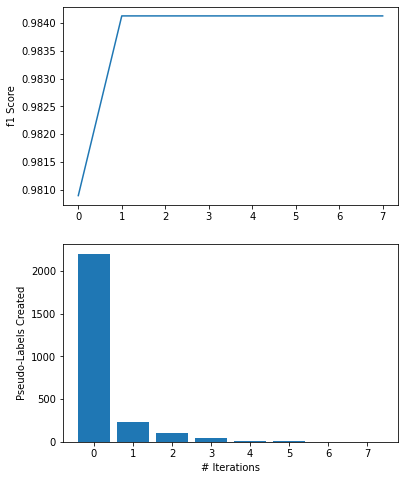

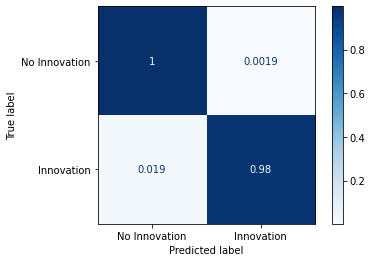

In [ ]:
# Plot f1 scores and number of pseudo-labels added for all iterations

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6,8))
ax1.plot(range(iterations), test_f1s)
ax1.set_ylabel('f1 Score')
ax2.bar(x=range(iterations), height=pseudo_labels)
ax2.set_ylabel('Pseudo-Labels Created')
ax2.set_xlabel('# Iterations');

# View confusion matrix after self-training

plot_confusion_matrix(log, X_test, y_test, cmap='Blues', normalize='true',
                     display_labels=['No Innovation', 'Innovation']);

## Train Second classifier for the last unlabelled data

In [ ]:
# Initiate iteration counter
iterations = 0

# Containers to hold f1_scores and # of pseudo-labels
train_f1s = []
test_f1s = []
pseudo_labels = []

# Assign value to initiate while loop
high_prob = [1] 

# Loop will run until there are no more high-probability pseudo-labels
while len(high_prob) > 0:
        
    # Fit classifier and make train/test predictions
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    y_hat_train = knn.predict(X_train)
    y_hat_test = knn.predict(X_test)

    # Calculate and print iteration # and f1 scores, and store f1 scores
    train_f1 = f1_score(y_train, y_hat_train)
    test_f1 = f1_score(y_test, y_hat_test)
    print(f"Iteration {iterations}")
    print(f"Train f1: {train_f1}")
    print(f"Test f1: {test_f1}")
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)
   
    if (len(X_unlabeled) > 0):
      # Generate predictions and probabilities for unlabeled data
      print(f"Now predicting labels for unlabeled data...")

      pred_probs : np.ndarray = knn.predict_proba(X_unlabeled)
      preds : np.ndarray = knn.predict(X_unlabeled)
      prob_0 : list = pred_probs[:,0]
      prob_1 : list = pred_probs[:,1]

      # Store predictions and probabilities in dataframe
      df_pred_prob : pd.DataFrame = pd.DataFrame([])
      df_pred_prob['preds'] = preds
      df_pred_prob['prob_0'] = prob_0
      df_pred_prob['prob_1'] = prob_1
      df_pred_prob.index = X_unlabeled.index
    
      # Separate predictions with > 99% probability
      high_prob : pd.DataFrame = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.99],
                           df_pred_prob.loc[df_pred_prob['prob_1'] > 0.99]],
                          axis=0)
    
      print(f"{len(high_prob)} high-probability predictions added to training data.")
    
      pseudo_labels.append(len(high_prob))

      # Add pseudo-labeled data to training data
      X_train = pd.concat([X_train, X_unlabeled.loc[high_prob.index]], axis=0)
      y_train = pd.concat([y_train, high_prob.preds])      
    
      # Drop pseudo-labeled instances from unlabeled data
      X_unlabeled = X_unlabeled.drop(index=high_prob.index)
      print(f"{len(X_unlabeled)} unlabeled instances remaining.\n")
    
      # Update iteration counter
      iterations += 1
    else :
      high_prob = []
      print(f'end of process.')

Iteration 0
Train f1: 0.9991098451130498
Test f1: 1.0
Now predicting labels for unlabeled data...
2490 high-probability predictions added to training data.
1047 unlabeled instances remaining.

Iteration 1
Train f1: 0.9994397759103641
Test f1: 1.0
Now predicting labels for unlabeled data...
574 high-probability predictions added to training data.
473 unlabeled instances remaining.

Iteration 2
Train f1: 0.999593165174939
Test f1: 1.0
Now predicting labels for unlabeled data...
311 high-probability predictions added to training data.
162 unlabeled instances remaining.

Iteration 3
Train f1: 0.9996150144369587
Test f1: 1.0
Now predicting labels for unlabeled data...
91 high-probability predictions added to training data.
71 unlabeled instances remaining.

Iteration 4
Train f1: 0.9996213555471413
Test f1: 1.0
Now predicting labels for unlabeled data...
29 high-probability predictions added to training data.
42 unlabeled instances remaining.

Iteration 5
Train f1: 0.999623423084165
Test f1:

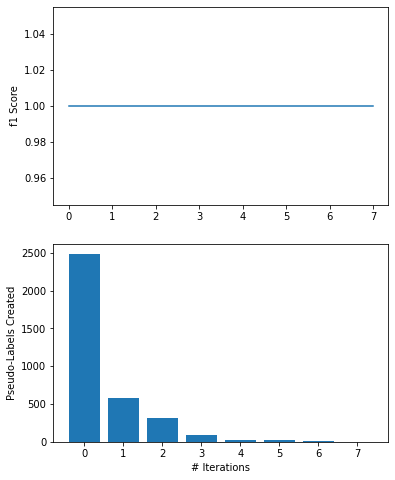

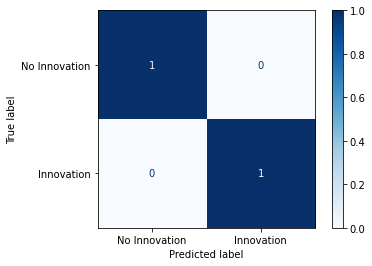

In [ ]:
# Plot f1 scores and number of pseudo-labels added for all iterations

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6,8))
ax1.plot(range(iterations), test_f1s)
ax1.set_ylabel('f1 Score')
ax2.bar(x=range(iterations), height=pseudo_labels)
ax2.set_ylabel('Pseudo-Labels Created')
ax2.set_xlabel('# Iterations');

# View confusion matrix after self-training

plot_confusion_matrix(knn, X_test, y_test, cmap='Blues', normalize='true',
                     display_labels=['No Innovation', 'Innovation']);

## If needed, third classifier

In [ ]:
# Initiate iteration counter
iterations = 0

# Containers to hold f1_scores and # of pseudo-labels
train_f1s = []
test_f1s = []
pseudo_labels = []

# Assign value to initiate while loop
high_prob = [1] 

# Loop will run until there are no more high-probability pseudo-labels
while len(high_prob) > 0:
        
    # Fit classifier and make train/test predictions
    clf = make_pipeline(StandardScaler(),
                     SGDClassifier(max_iter=1000, tol=1e-3,loss = 'log'))
    clf.fit(X_train, y_train)
    y_hat_train = clf.predict(X_train)
    y_hat_test = clf.predict(X_test)

    # Calculate and print iteration # and f1 scores, and store f1 scores
    train_f1 = f1_score(y_train, y_hat_train)
    test_f1 = f1_score(y_test, y_hat_test)
    print(f"Iteration {iterations}")
    print(f"Train f1: {train_f1}")
    print(f"Test f1: {test_f1}")
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)
   
    if (len(X_unlabeled) > 0):
      # Generate predictions and probabilities for unlabeled data
      print(f"Now predicting labels for unlabeled data...")

      pred_probs : np.ndarray = clf.predict_proba(X_unlabeled)
      preds : np.ndarray = clf.predict(X_unlabeled)
      prob_0 : list = pred_probs[:,0]
      prob_1 : list = pred_probs[:,1]

      # Store predictions and probabilities in dataframe
      df_pred_prob : pd.DataFrame = pd.DataFrame([])
      df_pred_prob['preds'] = preds
      df_pred_prob['prob_0'] = prob_0
      df_pred_prob['prob_1'] = prob_1
      df_pred_prob.index = X_unlabeled.index
    
      # Separate predictions with > 60% probability
      high_prob : pd.DataFrame = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.60],
                           df_pred_prob.loc[df_pred_prob['prob_1'] > 0.60]],
                          axis=0)
    
      print(f"{len(high_prob)} high-probability predictions added to training data.")
    
      pseudo_labels.append(len(high_prob))

      # Add pseudo-labeled data to training data
      X_train = pd.concat([X_train, X_unlabeled.loc[high_prob.index]], axis=0)
      y_train = pd.concat([y_train, high_prob.preds])      
    
      # Drop pseudo-labeled instances from unlabeled data
      X_unlabeled = X_unlabeled.drop(index=high_prob.index)
      print(f"{len(X_unlabeled)} unlabeled instances remaining.\n")
    
      # Update iteration counter
      iterations += 1
    else :
      high_prob = []
      print(f'end of process.')

Iteration 0
Train f1: 1.0
Test f1: 0.9931972789115647
end of process.


In [ ]:
X_test['innovation'] = y_test
test_end = X_test 

In [ ]:
X_train['innovation'] = y_train
train_end = X_train

In [ ]:
final = pd.concat([train_end,test_end])

In [ ]:
final['index'] = final.index

In [ ]:
df_final = pd.merge(left=df, right=final, left_on='index', right_on='index')

In [ ]:
df_final=df_final.drop(columns=['index','innovation_detection','Nb_key_words_y','Nb_key_words_title_y',
                                'ratio_key_words_y','ratio_key_word_title_y'])

In [ ]:
df_final = df_final.rename(columns = {'Nb_key_words_x': 'Nb_key_words', 'Nb_key_words_title_x': 'Nb_key_words_title',
                           'ratio_key_words_x' : 'ratio_key_words', 'ratio_key_word_title_x' : 'ratio_key_word_title',
                           'innovation' : 'innovation_features'})

In [ ]:
df_final.to_json("/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Output/Innovation/Res_Innovation_semi_supervised_Feature.json")